
## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
from torch.utils.data.sampler import SubsetRandomSampler

import sys,os
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/"))
from imp import reload 
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

import warnings
warnings.filterwarnings('ignore')

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # temporarily
# Fix random seeds for reproducibility
seed = 73
#torch.manual_seed(seed)
#np.random.seed(seed)

## Methods

In [2]:
def loader(field):
    if field == 'Mtot':
        fix = ""
    else:
        fix = "_"+field
    coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG{}_for_vib_total.npy".format(fix))
    gcoef_avg = np.zeros((1000, coef.shape[1]))
    for i in range(1000):
        gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
    coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA{}_for_vib_total.npy".format(fix))
    rcoef_avg = np.zeros((1000, coef.shape[1]))
    for i in range(1000):
        rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
    coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid{}_for_vib_total.npy".format(fix))
    acoef_avg = np.zeros((1000, coef.shape[1]))
    for i in range(1000):
        acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
    coef = np.r_[gcoef_avg, rcoef_avg, acoef_avg]


    fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
    gparams = np.loadtxt(fparam)
    gparams = gparams[:,:2] ## only Om and Sig8
    fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
    rparams = np.loadtxt(fparam)
    rparams = rparams[:,:2] ## only Om and Sig8
    fparam = "/mnt/home/fvillaescusa/CAMELS/Results/images_Astrid/params_LH_Astrid.txt" 
    aparams = np.loadtxt(fparam)
    aparams = aparams[:,:2] ## only Om and Sig8
    params  = np.r_[gparams, rparams, aparams]
    return coef, params

def loader_dmo(sim):
    fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Gadget/params_Gadget.txt"
    gparams = np.loadtxt(fparam)
    gparams = gparams[:,:2] ## only Om and Sig8
    fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Ramses/params_Ramses.txt"
    rparams = np.loadtxt(fparam)
    rparams = rparams[:,:2] ## only Om and Sig8
    params  = np.r_[gparams, rparams]

    coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nGadget_for_vib_total.npy")
    gcoef_avg = np.zeros((1000, coef.shape[1]))
    for i in range(1000):
        gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
    coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nRamses_for_vib_total.npy")
    rcoef_avg = np.zeros((1000, coef.shape[1]))
    for i in range(1000):
        rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
    coef = np.r_[gcoef_avg, rcoef_avg]
    if sim == "Gadget":
        return gcoef_avg, gparams
    if sim == "Ramses":
        return rcoef_avg, rparams
    if sim == "both":
        return coef, params

def make_dataset(coef,params):
    batch_size       = 100
    validation_split = .2
    shuffle_dataset  = True
    random_seed      = 42

    # Labelling for classification of simultions
    y_params   = torch.tensor(params,dtype=torch.float)
    y          = torch.zeros((y_params.shape[0],y_params.shape[1]+3))
    y[:,:2]    = y_params
    y[0:1000   ,2] = 1.
    y[1000:2000,3] = 1.
    y[2000:3000,4] = 1.


    X = torch.tensor(np.absolute(coef),dtype=torch.float)
    dataset      = data_utils.TensorDataset(X, y)
    dataset_size = len(dataset)
    indices      = list(range(dataset_size))
    split        = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices,:2])
    return train_loader, test_dataset

def print_score(test_dataset, vib, field):
    X, y            = test_dataset.tensors
    y_pred, y_sigma = vib(torch.tensor(X,dtype=torch.float).to(device))
    y_pred          = y_pred.cpu().detach().numpy()
    y               = y.cpu().detach().numpy()
    rele_om         = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
    rele_om         = rele_om.mean()
    r2_om           = sklearn.metrics.r2_score(y[:,0],y_pred[:,0])
    rele_sig        = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
    rele_sig        = rele_sig.mean()
    r2_sig          = sklearn.metrics.r2_score(y[:,1],y_pred[:,1])

    #print(rele_om)
    print("{}: Reletive Error=({:.3f}, {:.3f}), R2 score=({:.3f}, {:.3f})"\
          .format(field,rele_om,rele_sig,r2_om,r2_sig))


# Hydro to DM

In [37]:
# Hyperparameters
beta   = 1e-3
input_shape  = 3105
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000
batch_size = 100
field =  'Mtot'

coef, params = loader(field)
train_loader, test_dataset = make_dataset(coef, params)
vib = NDR(input_shape, output_shape,z_dim, num_models=3)
total_loss, accuracy = train_ndr(vib, train_loader, device, epochs,batch_size,test_dataset, verbose=False)
print_score(test_dataset,vib,field)

Mtot: Reletive Error=(0.054, 0.032), R2 score=(0.958, 0.923)


0.31582449375102134 0.34377858442388104 -0.581291890154982


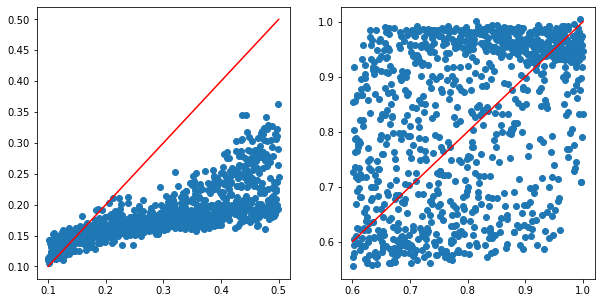

In [38]:
gcoef, y = loader_dmo("Gadget")

vib.eval()
y_pred, _ = vib(torch.tensor(gcoef,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel = (y[:,0]-y_pred[:,0])/y[:,0]
bias = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
print(rel.mean(), bias.mean(), sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))

fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])
plt.plot(ideal2,ideal2,"r")

0.43128770042569137 0.4425411619163074 -1.4430402390717219


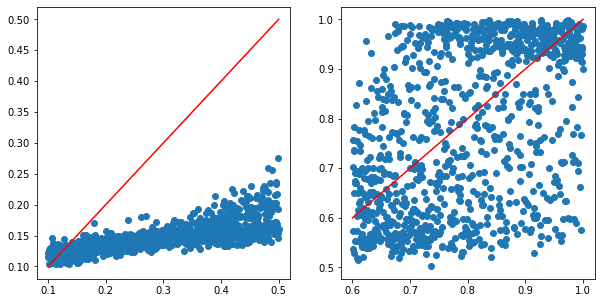

In [39]:
gcoef, y = loader_dmo("Ramses")

vib.eval()
y_pred, _ = vib(torch.tensor(gcoef,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel = (y[:,0]-y_pred[:,0])/y[:,0]
bias = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
print(rel.mean(), bias.mean(), sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))

fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])
plt.plot(ideal2,ideal2,"r")

# DM+Hydro

In [3]:
def make_dataset_dm(coef,params):
    batch_size       = 100
    validation_split = .2
    shuffle_dataset  = True
    random_seed      = 42

    # Labelling for classification of simultions
    y_params   = torch.tensor(params,dtype=torch.float)
    y          = torch.zeros((y_params.shape[0],y_params.shape[1]+4))
    y[:,:2]    = y_params
    y[0:1000   ,2] = 1.
    y[1000:2000,3] = 1.
    y[2000:3000,4] = 1.
    y[3000:4000,5] = 1.


    X = torch.tensor(np.absolute(coef),dtype=torch.float)
    dataset      = data_utils.TensorDataset(X, y)
    dataset_size = len(dataset)
    indices      = list(range(dataset_size))
    split        = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices,:2])

In [7]:
# Hyperparameters
beta   = 1e-3
input_shape  = 3105
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
batch_size = 100
epochs = 3000

gcoef, gparams = loader_dmo("Gadget")
coef, params = loader("Mtot")

coefall = np.r_[coef, gcoef]
paramall = np.r_[params,gparams]

train_loader, test_dataset = make_dataset(coefall, paramall)
vib = NDR(input_shape, output_shape,z_dim, num_models=3)
total_loss, accuracy = train_ndr(vib, train_loader, device, epochs,batch_size,test_dataset, verbose=True)
print_score(test_dataset,vib,field)

Epoch: 100/3000... Loss: -29.3664... Accuracy: 0.0020... Test Om: 0.140 sig: 0.078
Epoch: 200/3000... Loss: -76.0809... Accuracy: 0.0016... Test Om: 0.143 sig: 0.069
Epoch: 300/3000... Loss: -120.2858... Accuracy: 0.0014... Test Om: 0.096 sig: 0.080
Epoch: 400/3000... Loss: -158.0227... Accuracy: 0.0010... Test Om: 0.091 sig: 0.056
Epoch: 500/3000... Loss: -188.5085... Accuracy: 0.0009... Test Om: 0.079 sig: 0.048
Epoch: 600/3000... Loss: -212.4382... Accuracy: 0.0008... Test Om: 0.091 sig: 0.045
Epoch: 700/3000... Loss: -230.9025... Accuracy: 0.0006... Test Om: 0.075 sig: 0.047
Epoch: 800/3000... Loss: -244.9428... Accuracy: 0.0005... Test Om: 0.077 sig: 0.045
Epoch: 900/3000... Loss: -255.5202... Accuracy: 0.0004... Test Om: 0.079 sig: 0.047
Epoch: 1000/3000... Loss: -263.4467... Accuracy: 0.0003... Test Om: 0.082 sig: 0.047
Epoch: 1100/3000... Loss: -269.3565... Accuracy: 0.0002... Test Om: 0.082 sig: 0.048
Epoch: 1200/3000... Loss: -273.7733... Accuracy: 0.0002... Test Om: 0.082 si

NameError: name 'field' is not defined

0.46837539579267434 0.46892721546447774 -0.9167861058891067


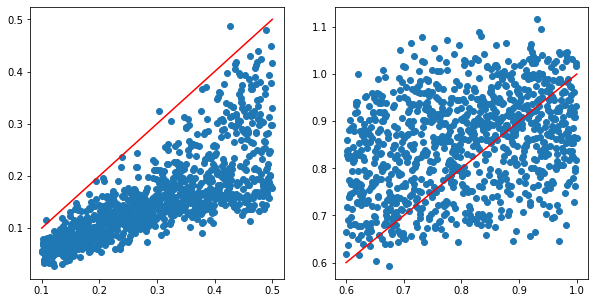

In [8]:
gcoef, y = loader_dmo("Gadget")

vib.eval()
y_pred, _ = vib(torch.tensor(gcoef,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel = (y[:,0]-y_pred[:,0])/y[:,0]
bias = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
print(rel.mean(), bias.mean(), sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))

fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])
plt.plot(ideal2,ideal2,"r")

0.5803353443093547 0.580389618602009 -1.7740594570023749


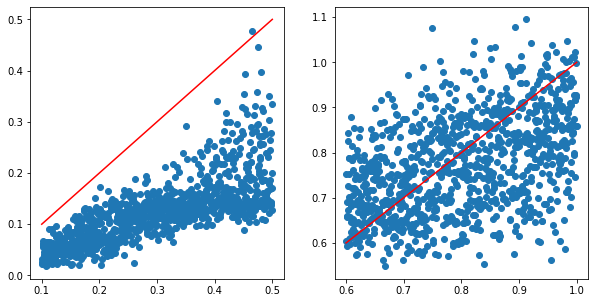

In [9]:
gcoef, y = loader_dmo("Ramses")

vib.eval()
y_pred, _ = vib(torch.tensor(gcoef,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel = (y[:,0]-y_pred[:,0])/y[:,0]
bias = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
print(rel.mean(), bias.mean(), sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))

fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])
plt.plot(ideal2,ideal2,"r")